In [1]:
# Import packages
from osgeo import gdal
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatabl
import numpy as np
import rasterio
import xarray
import rioxarray
import datetime

In [2]:
# Define filepaths
filepath7 = 'E:/GitHub/GEOG_L7/'
filepath8 = 'E:/GitHub/GEOG_L8/'
filepath_DF_mask = 'E:/GitHub/test_DF_area1_32610.tif'
filepath_DF_ownership = 'E:/GitHub/test_Ownership_DF_32610.tif'

# Define list of Landsat bands
files7 = sorted(glob.glob(filepath7 + '*.tif'))
files8 = sorted(glob.glob(filepath8 + '*.tif'))

## Below are functions to create NDVI images from the landsat tifs. Since landsat7 and landsat 8 use different bands to calculate NDVI we created two functions 

**process_ndvi_7** and **process_ndvi_8**

In [3]:
def process_ndvi_7(file):
    #strip name from filepath for later
    name = file  #.split("/")[-1]
    savename = file[-24:]
    #print(name
    #print(savename)
    xds = rioxarray.open_rasterio(file)
    
    #select band 4 and 3 from landsat 7 tif
    band4 = xds.sel(band=1)
    band3 = xds.sel(band=2)
    #band2 = xds.sel(band=3)
    
    # Compute NDVI
    ndvi = np.divide((band4 - band3), (band4 + band3))
    
    # clip to shape of Douglas Fire
    clipped_ndvi = ndvi.where(df_mask == 1)
    clipped_ndvi = clipped_ndvi.transpose('band', 'y', 'x')
    
    clipped_ndvi.rio.to_raster("E:/GitHub/landsat_ndvi/ndvi_"+savename)
    
def process_ndvi_8(file):
    name = file #.split("/")[-1]
    savename = file[-24:]
    #print(name)
    #print(savename)
    xds = rioxarray.open_rasterio(file)
    
    band5 = xds.sel(band=1)
    band4 = xds.sel(band=2)
    #band3 = xds.sel(band=3)
    
    # Compute NDVI
    #p.seterr(divide='ignore', invalid='ignore')
    ndvi = np.divide((band5 - band4), (band5 + band4))
                   
    # clip to shape of Douglas Fire
    clipped_ndvi = ndvi.where(df_mask == 1)
    clipped_ndvi = clipped_ndvi.transpose('band', 'y', 'x')               
    
    clipped_ndvi.rio.to_raster("E:/GitHub/landsat_ndvi/ndvi_"+savename)

In [4]:
df_mask = rioxarray.open_rasterio(filepath_DF_mask)
df_ownership = rioxarray.open_rasterio(filepath_DF_ownership)

In [5]:
for file in files7:
    process_ndvi_7(file)

for file in files8:
    process_ndvi_8(file)

Next task: apply ownership mask, and make either boxplot of each option for each image OR resample time if the plot is too messy AND/OR don't do boxplots, instead do scatter plot with standard deviation or something around each point?

In [6]:
def create_timeseries(files):
    times = []
    for name in files:
        times.append(name.split("_")[-1].split(".")[0])
        
    dates = []    
    for date in times:
        # format
        format = '%Y%m%d'

        # convert from string format to datetime format
        datetime_var = datetime.datetime.strptime(date, format)

        # get the date from the datetime using date()
        dates.append(datetime_var.date())
    return dates
        

def analyze_ownership(file):
    ndvi = rioxarray.open_rasterio(file)
    t = ndvi.squeeze(drop=True, axis=0)
    
    # 1 = private, 0 = BLM
    private_ndvi = ndvi.where(df_ownership == 1)
    private_ndvi = private_ndvi.squeeze(drop=True, axis=0)
    
    blm_ndvi = ndvi.where(df_ownership == 0)
    blm_ndvi = blm_ndvi.squeeze(drop=True, axis=0)
    
    return private_ndvi.values.flatten(), blm_ndvi.values.flatten()

In [7]:
filepath_ndvi = 'E:/GitHub/landsat_ndvi/'
files_ndvi = sorted(glob.glob(filepath_ndvi + '*.tif'))

times = create_timeseries(files_ndvi)
times.sort()

<xarray.DataArray (band: 3, y: 3895, x: 2361)>
[27588285 values with dtype=float32]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 4.416e+05 4.417e+05 ... 4.652e+05 4.652e+05
  * y            (y) float64 4.76e+06 4.76e+06 4.76e+06 ... 4.721e+06 4.721e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('SR_B4', 'SR_B3', 'SR_B2')

In [9]:
ownership_flattened_priv = []
ownership_flattened_blm = []

for file in files_ndvi:
    priv, blm = analyze_ownership(file)
    ownership_flattened_priv.append(priv)
    ownership_flattened_blm.append(blm)

In [10]:
for ii in range(len(ownership_flattened_priv)):
    ownership_flattened_priv[ii] = ownership_flattened_priv[ii][~np.isnan(ownership_flattened_priv[ii])]
for ii in range(len(ownership_flattened_blm)):
    ownership_flattened_blm[ii] = ownership_flattened_blm[ii][~np.isnan(ownership_flattened_blm[ii])]

In [76]:
datatest = pd.DataFrame(times, columns = ['Date'])
datatest['Date'] = pd.to_datetime(datatest['Date'])
datatest['Private'] = ownership_flattened_priv
datatest['BLM'] = ownership_flattened_blm
datatest

,Date,Private,BLM
0,2011-08-23,"[0.34109583, 0.3599262, 0.3599262, 0.3599262, ...","[0.3317753, 0.3259395, 0.3259395, 0.3259395, 0..."
1,2011-09-08,"[0.34334907, 0.35642722, 0.35642722, 0.3564272...","[0.35017365, 0.335354, 0.335354, 0.335354, 0.3..."
2,2011-09-24,"[0.015565863, 0.013135673, 0.013135673, 0.0131...","[0.19006391, 0.15339476, 0.15339476, 0.1533947..."
3,2011-10-26,"[0.39348057, 0.3307675, 0.3307675, 0.3307675, ...","[0.36812565, 0.361267, 0.361267, 0.361267, 0.3..."
4,2011-11-11,"[0.38336018, 0.3557022, 0.3557022, 0.3557022, ...","[0.37825766, 0.35632542, 0.35632542, 0.3563254..."
...,...,...,...
87,2021-07-25,"[0.36661595, 0.36954716, 0.36954716, 0.3695471...","[0.35095793, 0.34445423, 0.34445423, 0.3444542..."
88,2021-08-10,"[0.36135918, 0.364433, 0.364433, 0.364433, 0.4...","[0.3643079, 0.33856806, 0.33856806, 0.33856806..."
89,2021-08-26,"[0.36828753, 0.34677663, 0.34677663, 0.3467766...","[0.31658202, 0.33439463, 0.33439463, 0.3343946..."
90,2021-09-11,"[0.36627564, 0.34093526, 0.34093526, 0.3409352...","[0.25857455, 0.31589714, 0.31589714, 0.3158971..."


In [78]:
datatest.loc['2011']

KeyError: '2011'

In [52]:
June = [] #JuneJulyAugust = []
PrivJJ = []
BLMJJ = []
indJJ = []
for day in times:
    #print(day)
    if day.month in [5, 6, 7, 8, 9]: 
        June.append(day)
        PrivJJ.append(ownership_flattened_priv[times.index(datetime.date(day.year, day.month, day.day))])
        BLMJJ.append(ownership_flattened_blm[times.index(datetime.date(day.year, day.month, day.day))])
        indJJ.append(times.index(datetime.date(day.year, day.month, day.day)))

In [41]:
#calculate average for june/july prior to the burn
listtoavgPRIV = []
listtoavgBLM = []
for step in June:
    if step.year < 2013:
        meanP = PrivJJ[June.index(datetime.date(step.year, step.month, step.day))].mean()
        meanB = BLMJJ[June.index(datetime.date(step.year, step.month, step.day))].mean()
        listtoavgPRIV.append(meanP)
        listtoavgBLM.append(meanB)
        
meanPriv = np.mean(listtoavgPRIV)
#print(meanPriv)

meanBLM = np.mean(listtoavgBLM)
#print(meanBLM)

In [42]:
startSetP = PrivJJ[June.index(datetime.date(2013,6,1))]
startSetB = BLMJJ[June.index(datetime.date(2013,6,1))]

In [43]:
dndvi_priv = []
dndvi_blm = []
for ts in PrivJJ:
    if len(ts) == len(startSetP):
        #print(len(ts))
        dndvi_ts = (startSetP - ts)*1000 #np.divide((startSetP - ts),startSetP)*100
        dndvi_priv.append(dndvi_ts)
    
for ts in BLMJJ:
    if len(ts) == len(startSetB):
        #print(len(ts))
        dndvi_ts = (startSetB - ts)*1000 #np.divide((startSetB- ts),startSetB)*100
        dndvi_blm.append(dndvi_ts)

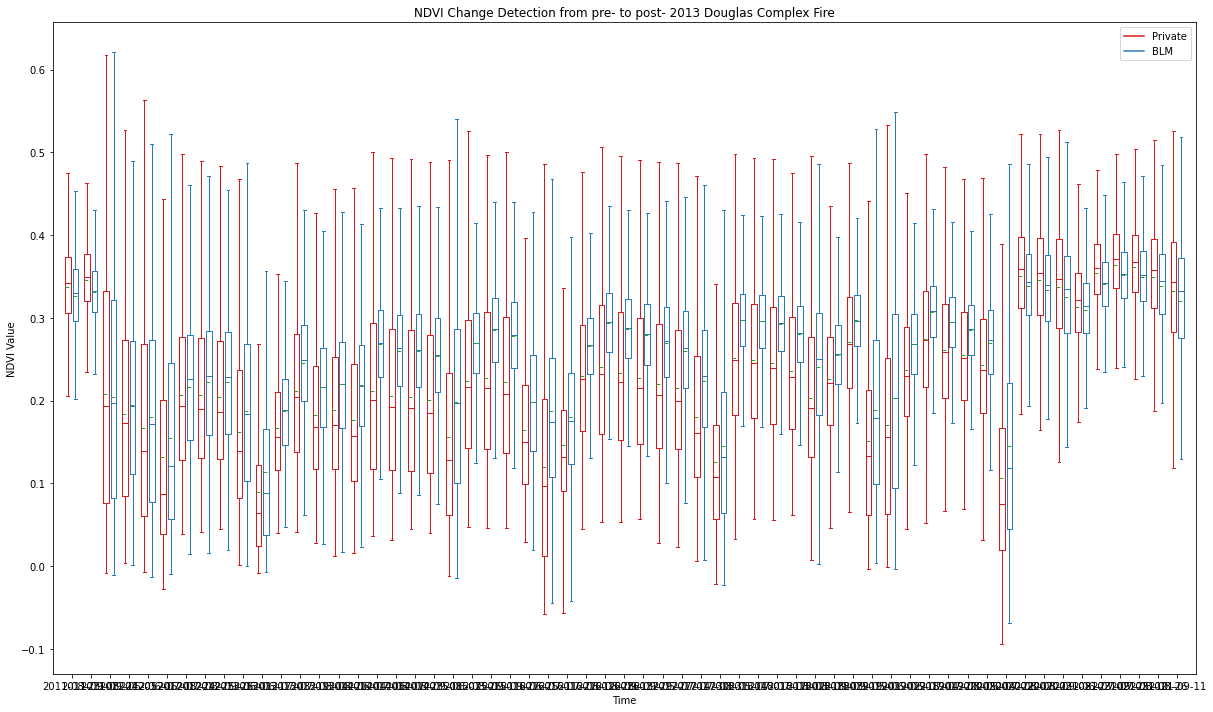

In [47]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(17, 10))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(PrivJJ, positions=np.array(range(len(PrivJJ)))*2.0-0.4, sym='', widths=0.6, showmeans=True, meanline=True)
bpblm = plt.boxplot(BLMJJ, positions=np.array(range(len(BLMJJ)))*2.0+0.4, sym='', widths=0.6, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.xticks(range(0, len(June) * 2, 2), June)
plt.xlim(-2,len(June)*2)
plt.xlabel('Time')
plt.ylabel('NDVI Value')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()
#plt.savefig('boxcompare.png')

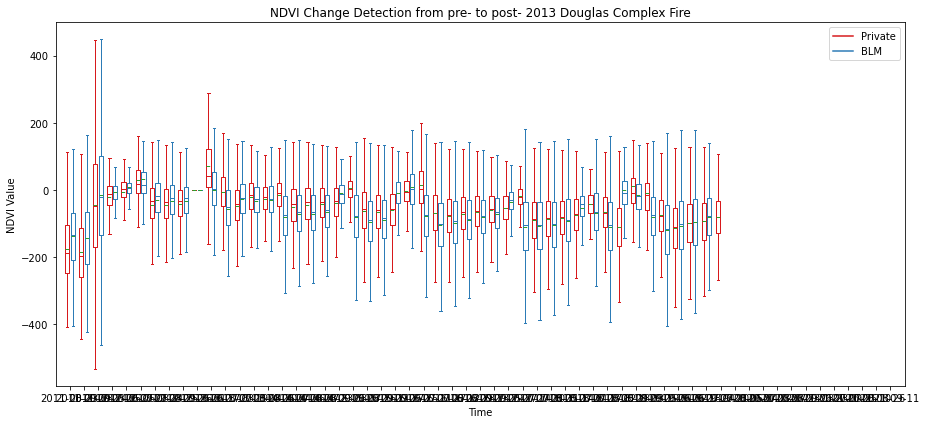

In [48]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(13, 6))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(dndvi_priv, positions=np.array(range(len(dndvi_priv)))*2.0-0.4, sym='', widths=0.6, showmeans=True, meanline=True)
bpblm = plt.boxplot(dndvi_blm, positions=np.array(range(len(dndvi_blm)))*2.0+0.4, sym='', widths=0.6, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.xticks(range(0, len(June) * 2, 2), June)
plt.xlim(-2,len(June)*2)
plt.xlabel('Time')
plt.ylabel('NDVI Value')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()
#plt.savefig('boxcompare.png')

In [ ]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(12, 20))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(PrivJJ, positions=np.array(range(len(PrivJJ)))*2.0-0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True)
bpblm = plt.boxplot(BLMJJ, positions=np.array(range(len(BLMJJ)))*2.0+0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.yticks(range(0, len(June) * 2, 2), June)
plt.ylim(len(June)*2,-2)
plt.ylabel('Time')
plt.xlabel('NDVI Value')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()
#plt.savefig('boxcompare.png')

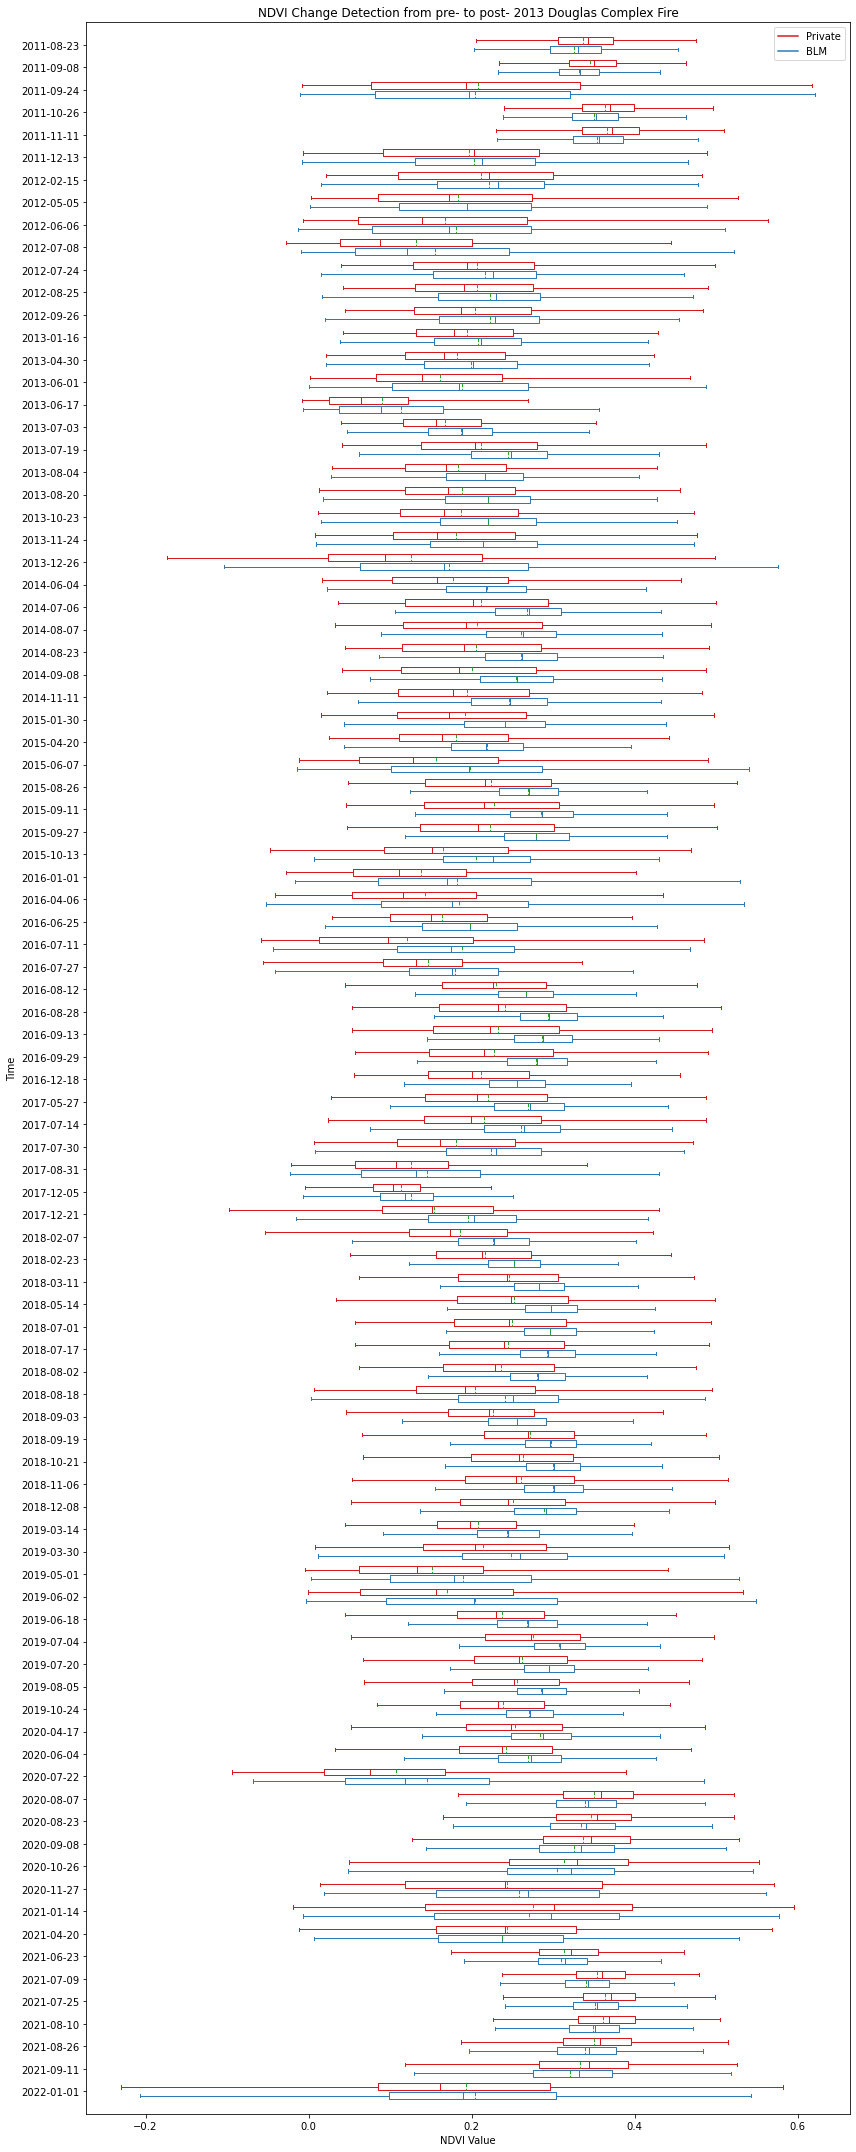

In [25]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(12, 30))

# vert = 0 for vertical boxplot, also switch y and x options
bppriv = plt.boxplot(ownership_flattened_priv, positions=np.array(range(len(ownership_flattened_priv)))*2.0-0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True)
bpblm = plt.boxplot(ownership_flattened_blm, positions=np.array(range(len(ownership_flattened_blm)))*2.0+0.4, sym='', widths=0.6, vert = 0, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.yticks(range(0, len(times) * 2, 2), times)
plt.ylim(len(times)*2,-2)
plt.ylabel('Time')
plt.xlabel('NDVI Value')
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire')
plt.tight_layout()
#plt.savefig('boxcompare.png')

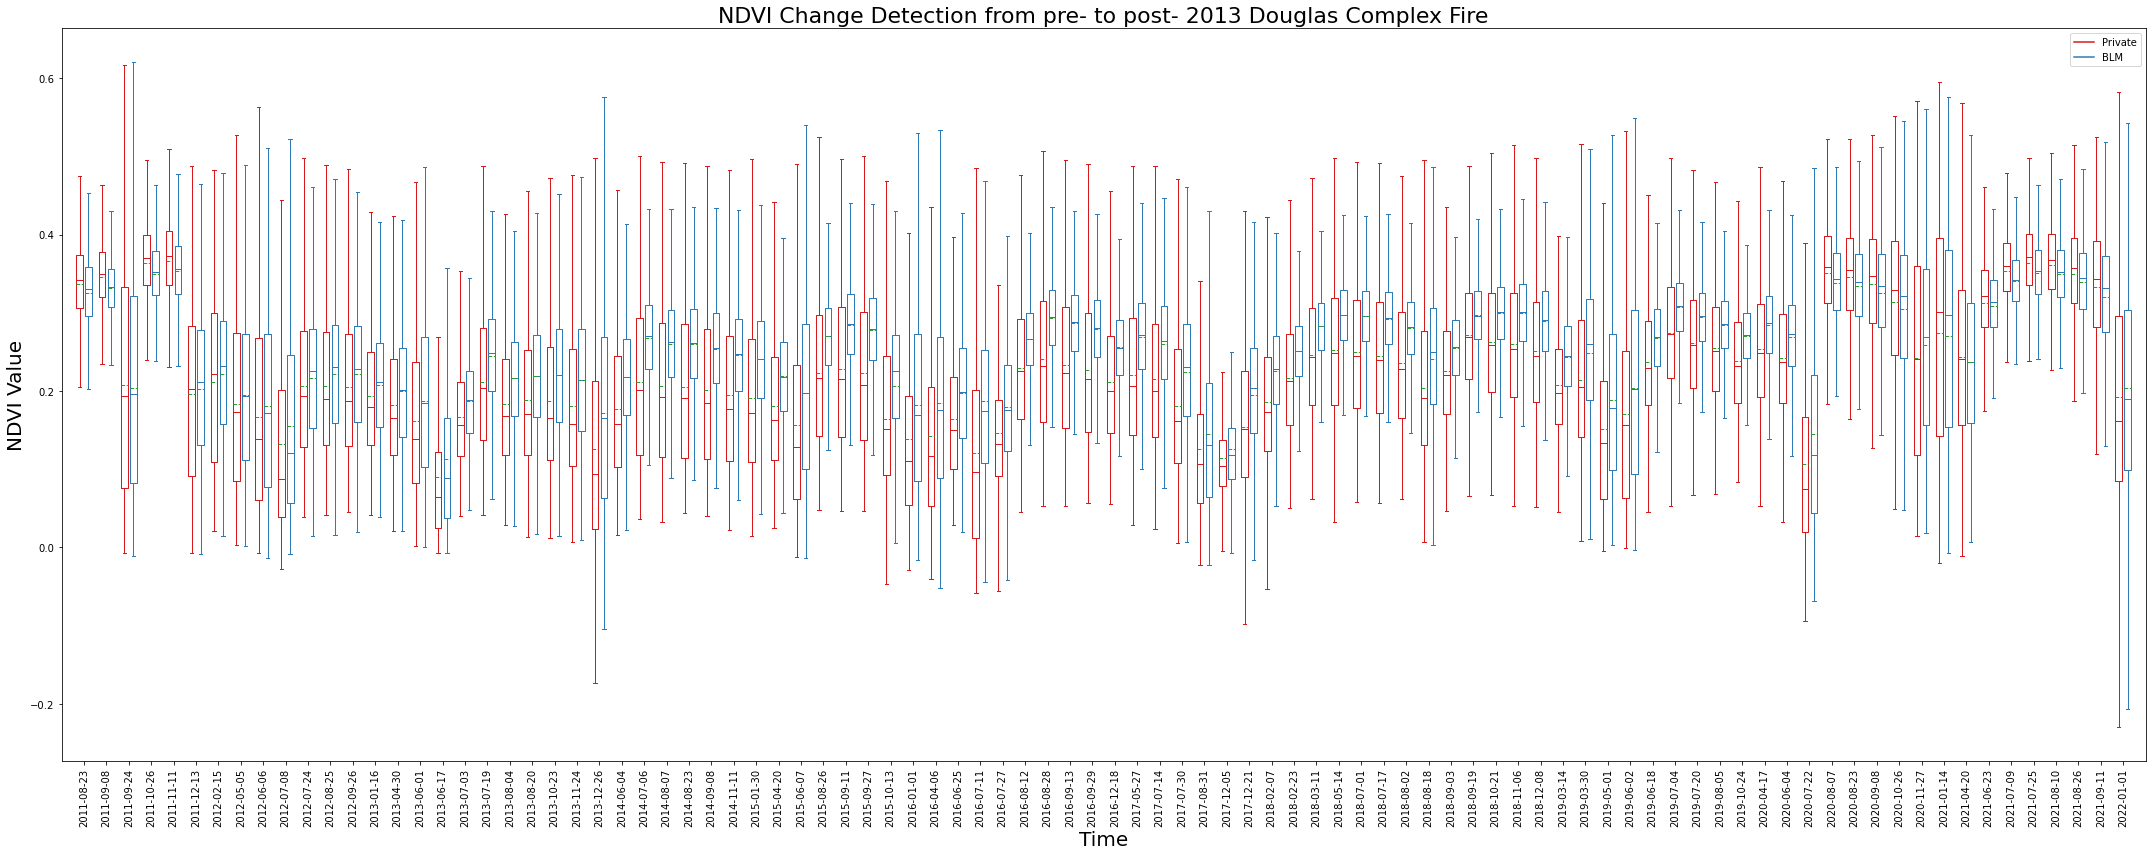

In [26]:
plt.figure(figsize=(30, 12))

bppriv = plt.boxplot(ownership_flattened_priv, positions=np.array(range(len(ownership_flattened_priv)))*2.0-0.4, sym='', widths=0.6, showmeans=True, meanline=True)
bpblm = plt.boxplot(ownership_flattened_blm, positions=np.array(range(len(ownership_flattened_blm)))*2.0+0.4, sym='', widths=0.6, showmeans=True, meanline=True)
set_box_color(bppriv, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpblm, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private')
plt.plot([], c='#2C7BB6', label='BLM')
plt.legend()

plt.xticks(range(0, len(times) * 2, 2), times)
plt.xlim(-2,len(times)*2)
plt.xticks(rotation=90)
plt.xlabel('Time', fontsize=20)
plt.ylabel('NDVI Value', fontsize=20)
plt.title('NDVI Change Detection from pre- to post- 2013 Douglas Complex Fire', fontsize=22)
plt.tight_layout()
#plt.savefig('boxcompare_horz.svg')

In [ ]:
#currently subscripted for horizontal boxplots. Change first subscript from 1 -> 0 to do vertical
means_priv = [list(item.get_data()[1])[0] for item in bppriv['means']]
means_blm = [list(item.get_data()[1])[0] for item in bpblm['means']]
q1_priv = [list(item.get_data()[1])[0] for item in bppriv['boxes']]
q3_priv = [list(item.get_data()[1])[2] for item in bppriv['boxes']]
q1_blm = [list(item.get_data()[1])[0] for item in bpblm['boxes']]
q3_blm = [list(item.get_data()[1])[2] for item in bpblm['boxes']]

In [ ]:
plt.figure(figsize=(10, 15))

x = np.arange(0, len(times[19:]))

z1 = np.polyfit(x, means_priv[19:], 1)
p1 = np.poly1d(z1)
plt.plot(p1(x), x, c='#D7191C')
         
z2 = np.polyfit(x, means_blm[19:], 1)
p2 = np.poly1d(z2)
plt.plot(p2(x), x, c='#2C7BB6')


zq1priv = np.polyfit(x, q1_priv[19:], 1)
pq1priv = np.poly1d(zq1priv)
         
zq3priv = np.polyfit(x, q3_priv[19:], 1)
pq3priv = np.poly1d(zq3priv)

zq1blm = np.polyfit(x, q1_blm[19:], 1)
pq1blm = np.poly1d(zq1blm)
         
zq3blm = np.polyfit(x, q3_blm[19:], 1)
pq3blm = np.poly1d(zq3blm)

plt.fill_between(x, pq1priv(x), pq3priv(x), color='#D7191C', alpha=0.2)
plt.fill_between(x, pq1blm(x), pq3blm(x), color='#2C7BB6', alpha=0.2)


# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private: %s' %(str(p1)))
plt.plot([], c='#2C7BB6', label='BLM: %s' %(str(p2)))
plt.legend()

plt.yticks(x, times[19:]);
plt.ylim(len(times[19:]),-2);
plt.ylabel('Time')
plt.xlabel('Mean NDVI Value')
plt.title('NDVI Recovery Trend Post-Fire')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15, 10))

x = np.arange(0, len(times[19:]))

z1 = np.polyfit(x, means_priv[19:], 1)
p1 = np.poly1d(z1)
plt.plot(x, p1(x), c='#D7191C')
         
z2 = np.polyfit(x, means_blm[19:], 1)
p2 = np.poly1d(z2)
plt.plot(x, p2(x), c='#2C7BB6')

zq1priv = np.polyfit(x, q1_priv[19:], 1)
pq1priv = np.poly1d(zq1priv)
         
zq3priv = np.polyfit(x, q3_priv[19:], 1)
pq3priv = np.poly1d(zq3priv)

zq1blm = np.polyfit(x, q1_blm[19:], 1)
pq1blm = np.poly1d(zq1blm)
         
zq3blm = np.polyfit(x, q3_blm[19:], 1)
pq3blm = np.poly1d(zq3blm)

plt.fill_between(x, pq1priv(x), pq3priv(x), color='#D7191C', alpha=0.2)
plt.fill_between(x, pq1blm(x), pq3blm(x), color='#2C7BB6', alpha=0.2)

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Private: %s' %(str(p1)))
plt.plot([], c='#2C7BB6', label='BLM: %s' %(str(p2)))
plt.legend()

plt.xticks(x, times[19:]);
plt.xlim(-2,len(times[19:]));
plt.xticks(rotation=90)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Mean NDVI Value', fontsize=18)
plt.title('NDVI Recovery Trend Post-Fire', fontsize=20)
plt.tight_layout()
#plt.savefig('trendlines_horz.svg')